# Continuous actions using split MLP

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import warnings

warnings.filterwarnings('ignore')

You can skip training and instead load the last trained policy by changing the flag below.

In [9]:
from navground.learning.utils.jupyter import skip_if, run_if

training = True

## MASAC

In [10]:
from navground.learning import DefaultObservationConfig, DefaultStateConfig
from navground.learning.config.control_action_with_comm import ControlActionWithCommConfig
from navground.learning.examples.pad import get_env, comm, marker, PadReward
from navground.learning.scenarios.pad import render_kwargs

name = "DistributedCommFloatWithRewardSharing"
comm_size = 1
kwargs = render_kwargs(comm=True, low=-1, high=1, 
                       color_low=(1, 0, 0), color_high=(0, 1, 0))
action = ControlActionWithCommConfig(use_acceleration_action=True, max_acceleration=1, 
                                     fix_orientation=True, comm_size=comm_size)
observation = DefaultObservationConfig(flat=False, include_velocity=True, include_target_direction=False)
state = DefaultStateConfig(include_y=False, include_position=True, include_velocity=True)
sensors = [comm(size=comm_size, binarize=False), marker()]
train_env = get_env(action=action, observation=observation, state=state,
                    sensors=sensors, start_in_opposite_sides=False, 
                    reward=PadReward(neighbor_weight=0.5), include_success=False)
test_env = get_env(action=action, observation=observation, sensors=sensors, state=state,
                   start_in_opposite_sides=True, 
                   include_success=True, init_success=False, intermediate_success=True, 
                   render_mode='rgb_array', render_kwargs=kwargs)

In [11]:
%%skip_if $training

import pathlib, os
from navground.learning.utils.benchmarl import NavgroundExperiment

path = max(pathlib.Path(f'logs/{name}/MASAC-SplitModel').glob('*/checkpoints/*.pt'), key=os.path.getmtime)
experiment = NavgroundExperiment.reload_from_file(str(path))
experiment.folder_name

In [12]:
%%run_if $training

import os
from benchmarl.algorithms import MasacConfig
from benchmarl.models.mlp import MlpConfig
from navground.learning.utils.benchmarl.split_mlp import SplitMlpConfig
from benchmarl.experiment import ExperimentConfig
from navground.learning.utils.benchmarl import NavgroundExperiment, ExportPolicyCallback

algorithm = MasacConfig.get_from_yaml()
mlp = MlpConfig.get_from_yaml()
mlps_specs = [(1, None, {'num_cells': [256, 256]}), (1, ['pad/x', 'ego_velocity'], {'num_cells': [256, 256]})]
model = SplitMlpConfig(num_cells=mlp.num_cells, layer_class=mlp.layer_class,
                       activation_class=mlp.activation_class, activation_kwargs=mlp.activation_kwargs, 
                       norm_class=mlp.norm_class, norm_kwargs=mlp.norm_kwargs,
                       mlps_specs=mlps_specs)

config = ExperimentConfig.get_from_yaml()
config.loggers = [ 'csv']
config.render = True
config.evaluation_interval = 6000
config.evaluation_episodes = 30
config.lr = 3e-4
config.max_n_iters = 1
config.checkpoint_at_end = True
config.save_folder = f'logs/{name}/MASAC-SplitModel'
os.makedirs(config.save_folder, exist_ok=True)
experiment_masac = NavgroundExperiment(
    env=train_env,
    eval_env=test_env,
    config=config,
    model_config=model,
    critic_model_config=mlp,
    algorithm_config=algorithm,
    seed=0,
    callbacks=[ExportPolicyCallback()]
)
experiment_masac.folder_name

PosixPath('logs/DistributedCommFloatWithRewardSharing/MASAC-SplitModel/masac_navground_splitmlp__44bff93e_25_05_21-16_09_42')

In [13]:
experiment_masac.policy[0][0][0].mlps

[MultiAgentMLP(
     MLP(
       (0): Linear(in_features=3, out_features=256, bias=True)
       (1): Tanh()
       (2): Linear(in_features=256, out_features=256, bias=True)
       (3): Tanh()
       (4): Linear(in_features=256, out_features=2, bias=True)
     ),
     n_agents=2,
     share_params=True,
     centralized=False,
     agent_dim=-2),
 MultiAgentMLP(
     MLP(
       (0): Linear(in_features=2, out_features=256, bias=True)
       (1): Tanh()
       (2): Linear(in_features=256, out_features=256, bias=True)
       (3): Tanh()
       (4): Linear(in_features=256, out_features=2, bias=True)
     ),
     n_agents=2,
     share_params=True,
     centralized=False,
     agent_dim=-2)]

In [14]:
%%run_if $training

experiment_masac.run_for(iterations=40)

mean return = -6.207028388977051: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [18:26<00:00, 27.66s/it]


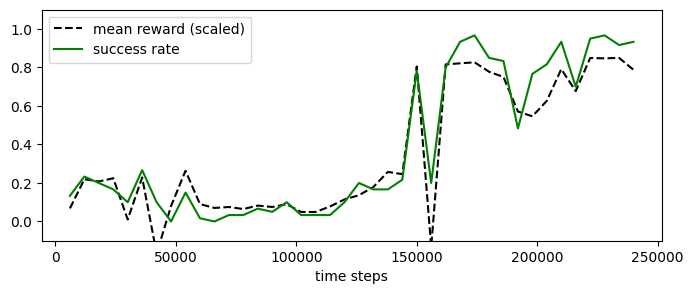

In [15]:
experiment_masac.plot_eval_logs(reward_low=-200, reward_high=0, 
                                success=True, figsize=(8, 3))

In [17]:
from stable_baselines3.common.evaluation import evaluate_policy
from navground.learning.parallel_env import make_vec_from_penv

test_venv = make_vec_from_penv(test_env)
policy_masac = experiment_masac.load_policy(name='best_policy')
evaluate_policy(policy_masac, test_venv, n_eval_episodes=30)

(-30.328231702248257, 30.494501651731493)

In [18]:
from navground.learning.evaluation.video import display_episode_video

display_episode_video(test_env, policy=policy_masac, factor=4, select=2, of=31, **kwargs)

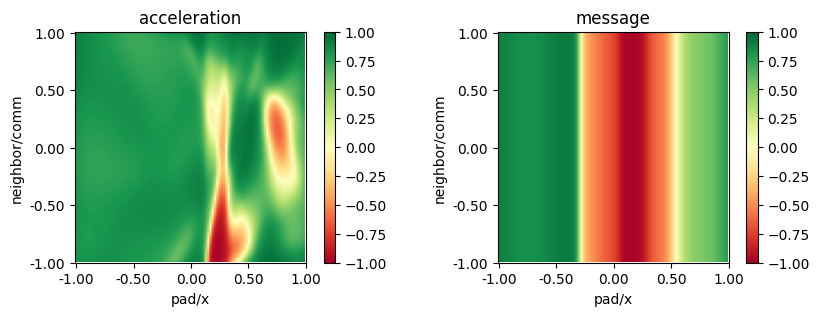

In [20]:
from navground.learning.utils.plot import plot_policy

plot_policy(policy_masac, 
            variable={'pad/x': (-1, 1), 'neighbor/comm': (-1, 1)},
            fix={'ego_velocity': 0.1},
            actions={0: 'acceleration', 1: 'message'}, width=5, height=3)

## Alternate Action and Communication training

In [21]:
%%skip_if $training

import pathlib, os
from navground.learning.utils.benchmarl import NavgroundExperiment

path = max(pathlib.Path(f'logs/{name}/MASAC-AltModel').glob('*/checkpoints/*.pt'), key=os.path.getmtime)
experiment = NavgroundExperiment.reload_from_file(str(path))
experiment.folder_name

In [22]:
%%run_if $training

from navground.learning.utils.benchmarl.callbacks import AlternateActorCallback

learning_rates = [(2, 3e-4), (2, 1e-3)] 
alt_cb = AlternateActorCallback(loss='loss_actor', 
                                learning_rates=learning_rates)
config = ExperimentConfig.get_from_yaml()
config.loggers = [ 'csv']
config.render = True
config.evaluation_interval = 6000
config.evaluation_episodes = 30
config.lr = 3e-4
config.max_n_iters = 1
config.checkpoint_at_end = True
config.save_folder = f'logs/{name}/MASAC-AltModel'
os.makedirs(config.save_folder, exist_ok=True)
experiment_masac_alt = NavgroundExperiment(
    env=train_env,
    eval_env=test_env,
    config=config,
    model_config=model,
    critic_model_config=mlp,
    algorithm_config=algorithm,
    seed=0,
    callbacks=[ExportPolicyCallback(), alt_cb]
)
experiment_masac_alt.folder_name

PosixPath('logs/DistributedCommFloatWithRewardSharing/MASAC-AltModel/masac_navground_splitmlp__013da278_25_05_21-16_30_29')

In [23]:
%%run_if $training

experiment_masac_alt.run_for(iterations=40)

mean return = -5.425860404968262: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [20:17<00:00, 30.43s/it]


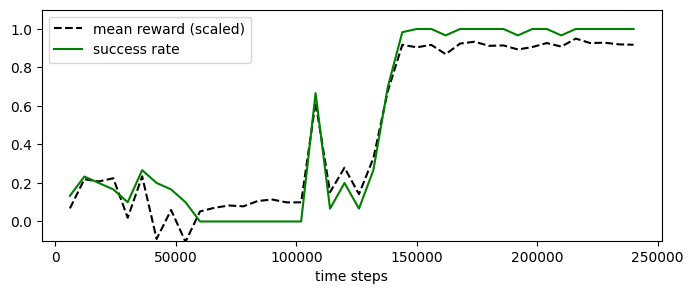

In [24]:
experiment_masac_alt.plot_eval_logs(reward_low=-200, reward_high=0, 
                                    success=True, figsize=(8, 3))

In [29]:
policy_masac_alt = experiment_masac_alt.load_policy(name='best_policy')
evaluate_policy(policy_masac_alt, test_venv, n_eval_episodes=30)

(-11.591048258543015, 13.943050052673952)

In [32]:
display_episode_video(test_env, policy=policy_masac_alt, factor=4, select=15, of=31, **kwargs)

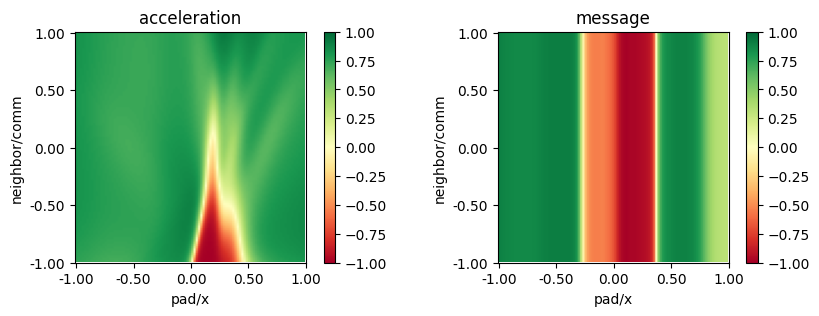

In [31]:
plot_policy(policy_masac_alt, 
            variable={'pad/x': (-1, 1), 'neighbor/comm': (-1, 1)},
            fix={'ego_velocity': 0.1},
            actions={0: 'acceleration', 1: 'message'}, width=5, height=3)